# **Cluster Implementation Scrypt**

The following scrypt walks through a rudimentary implementation of *K-nearest Neighbors Clustering* for our Hit Songs Lyrics Database, a machine learning model that enables visualization of our NLP datapoint clusters. 

This is an unsupervised learning method. Hence, we are not attempting to elicit a causal relationship between lyrics and song characteristics, but rather, observe how songs naturally group together based on TF-IDF scoring, sentiment, word counts, and other numerical corpus properties.

We take on the following steps in order to complete this analysis (analysis with graphs are shown in bold below):

1. Package/function loading and functional imports
2. CSV Cleaning
3. Numerical Datapoint Aggregation (TF-IDF, sentiment, subjectivity, word count, unique word count, rank)
4. Clustering
5. **Time Period Analysis**
6. **Chart Rank Analysis**

## 1. Package/function loading and functional imports

We load in the necessarsy python functionalities for our analysis. In addition to KMeans, we utilize TF-IDF capabilities and scaling capabilities from sklearn.

In [1]:
import pandas as pd # used for data manipulation / concatenation
from sklearn.cluster import KMeans # primary ML package
from sklearn.feature_extraction.text import TfidfVectorizer # used for TF-IDF implementation
from sklearn.preprocessing import StandardScaler # scaling data for KMeans
import matplotlib.pyplot as plt # plotting and visualizing takeaways from our clustering analysis
import numpy as np # complimentary to matplotlib and pandas (anticipated use)
from textblob import TextBlob # rudimentary sentiment analysis
import sys # loading in functions contained in our repository

We also choose to load in functions from two separate *.py* files for the purposes of concision in this document:
- *csv_cleaning* for isolation of our desired parameters
- *clustering* for our clustering-specific functions and implementations

In [2]:
sys.path.append('.')

from functions.csv_cleaning import load_in, remove_links, remove_nan, clean_data
from functions.clustering import tf_idf, append_sent_and_subj, punctuation, inertia_plot, cluster_model, rank_var, visualize_variables

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thefleok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. CSV cleaning

We load in our CSV file and perform cleaning functions (see *csv_cleaning* for specific functional code) in order to isolate desired variables for local analysis.

In [3]:
df_raw = load_in() # load_in imports our raw data file from the desired folder
df_basic = clean_data(df_raw) # clean_data removes unecessary columns with links and data "noise"

# we visualize our data to get a sense of what the cleaned data set provides
df_basic.head(3)

,Song Title,Artist,Lyrics,Year,Rank,Word Counts,Unique Word Counts
0,The Battle Of New Orleans,Johnny Horton,In 1814 we took a little trip Along with Colo...,1959.0,1,435,155
1,Mack The Knife,Bobby Darin,"Oh the shark, babe Has such teeth, dear And he...",1959.0,2,224,145
2,Personality,Lloyd Price,Over and over I tried to prove my love to you ...,1959.0,3,215,55


## 3. Numerical Datapoint Aggregation (TF-IDF, sentiment, subjectivity, punctuation, word count, unique word count, rank)
Our *df_basic* dataset already has Rank, Year, Word Counts, and Unique Word Counts variables. We would like to gather an additional ollection of variables for comprehensive / accurate clustering. We will gather TF-IDF scores for the top 10 words, subjectivity scores, sentiment scores, and punctuation frequency scores (question/exclamation).

### a. TF-IDF Implementation
Claude Sonnet 4.5, can you describe TF-IDF in two sentences cause I don't want to write it?

*"TF-IDF measures how important a word is to a specific document by balancing how frequently it appears in that document against how common it is across all documents. Words that appear often in one document but rarely in others get high scores, while common words that appear everywhere get low scores."*

The function from *clustering.py* creates an array and then concatenates it into a pandas dataframe with rows compatible with our existing df. It will be concatenated with the rest of our values at the conclusion of this section.

In [4]:
tfidf_df = tf_idf(df_basic, 10).copy() # tf_idf function implements basic tf_idf functionality on desired number of words (in our case 10)

# Visualize the data
tfidf_df.head(3)

,baby,don,got,just,know,let,like,love,want,yeah
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,0.0,1.0
1,0.0,0.179567,0.000000,0.900227,0.349594,0.0,0.18743,0.00000,0.0,0.0
2,0.0,0.000000,0.807469,0.000000,0.000000,0.0,0.00000,0.58991,0.0,0.0


### b. Sentiment / Subjectivity Implementation
We gather from rudimentary textblob package implementation parameters that qualify sentiment (positive vs. negative) and subjectivity (weighted average of subjectivity of all words present in corpus). We append these to our existing df_basic dataframe for ease of concatenation later.

In [5]:
sent_and_subj_df = append_sent_and_subj(df_basic) # apply sentiment and subjectivity function from clustering.py

# visualize to verify appending success
sent_and_subj_df.head(3)

,Song Title,Artist,Lyrics,Year,Rank,Word Counts,Unique Word Counts,sentiment,subjectivity
0,The Battle Of New Orleans,Johnny Horton,In 1814 we took a little trip Along with Colo...,1959.0,1,435,155,0.066681,0.391962
1,Mack The Knife,Bobby Darin,"Oh the shark, babe Has such teeth, dear And he...",1959.0,2,224,145,-0.008757,0.219392
2,Personality,Lloyd Price,Over and over I tried to prove my love to you ...,1959.0,3,215,55,0.433333,0.436111


### c. Punctuation
We use two simple functions to gather and append frequeny of question marks and frequency of exclamation marks. We append to the sentiment/basic datapoint dataframe for ease of concatenation in the next step.

In [6]:
punctuation_df = punctuation(sent_and_subj_df) # add counts of question marks/exclamations with clustering.py function

# visualize and verify
punctuation_df.head(3)

,Song Title,Artist,Lyrics,Year,Rank,Word Counts,Unique Word Counts,sentiment,subjectivity,question_count,exclamation_count
0,The Battle Of New Orleans,Johnny Horton,In 1814 we took a little trip Along with Colo...,1959.0,1,435,155,0.066681,0.391962,0,0
1,Mack The Knife,Bobby Darin,"Oh the shark, babe Has such teeth, dear And he...",1959.0,2,224,145,-0.008757,0.219392,3,2
2,Personality,Lloyd Price,Over and over I tried to prove my love to you ...,1959.0,3,215,55,0.433333,0.436111,0,0


### d. Aggregation
We concatenate our existing dataframes and display our data for confirmation of successful aggregation. We drop string-like parameters such as "Artist" that are not available for clustering work.

In [7]:
# concatenate
cluster_df = pd.concat([tfidf_df, punctuation_df[['sentiment', 'subjectivity', 'Year', 'Word Counts', 'Unique Word Counts','Rank', 'question_count','exclamation_count']]], axis=1).dropna()

# visualize
cluster_df.head(3)

,baby,don,got,just,know,let,like,love,want,yeah,sentiment,subjectivity,Year,Word Counts,Unique Word Counts,Rank,question_count,exclamation_count
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,0.0,1.0,0.066681,0.391962,1959.0,435.0,155.0,1.0,0.0,0.0
1,0.0,0.179567,0.000000,0.900227,0.349594,0.0,0.18743,0.00000,0.0,0.0,-0.008757,0.219392,1959.0,224.0,145.0,2.0,3.0,2.0
2,0.0,0.000000,0.807469,0.000000,0.000000,0.0,0.00000,0.58991,0.0,0.0,0.433333,0.436111,1959.0,215.0,55.0,3.0,0.0,0.0


## 4. Clustering
With our clustering datapoints aggregated into one comprehensive dataframe, we initiate the clustering process. KMeans uses Euclidean distance by default, meaning we must scale our datapoints to a mean of 0 and a standard deviation of 1 using the StandardScaler function. We then Plot the inertia of k values 1-40 to determine an optimal cluster amount (k). Finally, we enact that number of clusters and verify correct implementation.

### a. Scaling
We scale the data points and verify successful scaling.

In [8]:
X = cluster_df.copy() # create copy for X values to scale

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # use StandardScaler() to scale our datapoints

In [9]:
# check that scaling worked (mean = 0, std = 1)
print(X_scaled.mean())
print(X_scaled.std())

1.5511937413571609e-16
1.0


### b. Inertia Plot
Claude Sonnet 4.5, why do we plot inertia for KMeans in 2 sentences? Don't feel like writing it

*Inertia measures how tightly clustered the data points are within their assigned clusters (lower is better). Plotting inertia across different values of k helps us find the "elbow point" where adding more clusters stops providing significant improvement, indicating the optimal number of clusters.*

Our available inertia_plot function from *clustering.py* enables us to run K-Means for k-values 2-40 and plot the corresponding inertia (tightness of clustering). We determine that k=13 is the appropriate elbow point (jagged shift in the derivative of our resulting graph).

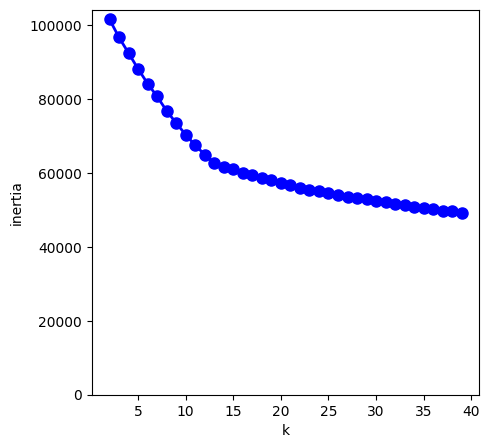

In [10]:
inertia_plot(X_scaled) # inertia_plot function will iterate through k = [2, 40]

### Cluster Analysis
We performing clustering on our dataframe to produce fit_df, which contains predictions for the correct clusters of all of our datapoints. We print the result of the "k_cluster" column to verify proper assignment.

In [11]:
fit_df = cluster_model(cluster_df, X_scaled, 13) # use cluster_model function to implement

# Visualize first 5 rows of "k_cluster" column
fit_df["k_cluster"].head(5)

0    12
1     9
2     1
3     0
4     0
Name: k_cluster, dtype: int32

## **5. Time Period Analysis**
This section contains the primary goal of our clustering analysis. In summary, we are attempting to utilize an unsupervised learning model in order to understand the variables that typically cluster with older songs and newer songs. This will paint a picture of the variables (and their corresponding values) typically associated with the newest and oldest songs in our dataset of top hits. The differences in these parameters will shine light on how variables change over time.
### a. Ranking by year and aggregating averages
We begin by ranking all of our clusters by the average year and isolating the newest and oldest clusters.

In [12]:
rank_var(fit_df, "Year") # rank clusters by average year from oldest to newest

Max: 2023.0
Min: 1959.0
k_cluster
0     1979.726596
9     1984.877470
4     1986.020000
1     1989.790323
3     1990.593117
6     1990.868217
11    1991.613636
10    1992.609914
8     1995.730159
12    1995.914634
2     2000.425926
5     2000.862847
7     2005.993658
Name: Year, dtype: float64


Our dataset extends from 1959 to 2023. Our clusters go from 1979 (oldest average) to 2005 (newest average), which encompasses a significant portion of the total band on years. This means that we have potential to show strong differences between oldest and newest songs based on clustering.  

Next we gather the averages for each of our variables across all clusters and for individual clusters, isolating clusters 0 and 7 (oldest and newest):

In [13]:
overall_mean = fit_df.mean() # mean across all clusters

# Display to verify successful computation
overall_mean.head(3)

baby    0.163975
don     0.197333
got     0.154585
dtype: float64

In [14]:
cluster_averages = fit_df.groupby('k_cluster').mean() # columns represent clusters

In [15]:
# isolate clusters 0 and 7 (oldest and newest)
cluster_0 = cluster_averages.iloc[0]
cluster_7 = cluster_averages.iloc[7]

In [16]:
# concatenate
comparison = pd.concat([overall_mean, cluster_0, cluster_7], axis=1)

We visualize our total mean, cluster 0 mean, and cluster 7 mean. We will compare values and magnitudes of differences for our final analysis.

In [17]:
comparison.columns = ['total mean', 'cluster 0 mean', 'cluster 7 mean'] # rename columns
# display aggregated averages
comparison.dropna()

,total mean,cluster 0 mean,cluster 7 mean
baby,0.163975,0.066759,0.177107
don,0.197333,0.077785,0.237424
got,0.154585,0.047015,0.201532
just,0.183099,0.079962,0.205634
know,0.193364,0.090276,0.243989
let,0.125657,0.047810,0.118083
like,0.191393,0.075340,0.242032
love,0.251918,0.775572,0.227998
want,0.109905,0.045309,0.093115
yeah,0.161614,0.043766,0.201220


### b. Visualize relationships in data

Using the *visualize_variables* function from our *clustering.py* scrypt, we can easily plot variables against each other for desired clusters (in this case, 0 and 7). We will Plot variables of interest that show key differences across the oldest and newest clusters. 

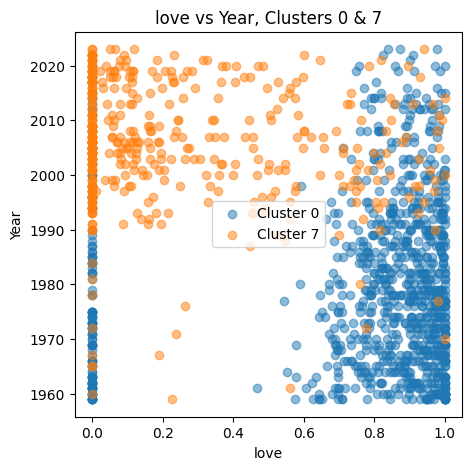

In [18]:
visualize_variables(fit_df, "love", "Year",0,7)

**Analysis:** Looking at the comparison table right above 5b, it is clear that clusters 0 and 7 (oldest and newest respectively) differ substantially on the TF-IDF of the term "love" in their clusters. The TF-IDF of "love" is technically a proxy for the TF of love. The IDF term (inverse document frequency) is constant because across all documents, the IDF for love is being calculated on our entire dataset. Thus, we can assume that a higher TF-IDF of love is a higher TF of love in a particular corpus of lyrics. We see that interestingly, for songs in cluster 0 (predominantly older songs from 1960-1990), mention love either in excess or not at all. TF-IDF tends to exceed 0.6 or remain flatlined at 0.

For the newest songs predominantly dated after 1990 (cluster 7), the TF-IDF for love is much lower. When it is larger than 0, it tends to be more spread out between 0 and 1, with few songs matching the TF-IDF of most of the cluster 0 songs. This is an interesting finding; it suggests newer songs tend to cluster with a lower TF-IDF of "love" very strongly, and that newer songs tend to be more evenly spread out with their TF-IDF (i.e. TF) when mentioning the word. Old songs, on the other hand, much more frequently mention "love" in the oldest cluster and are more extreme (either no love or lots of it).

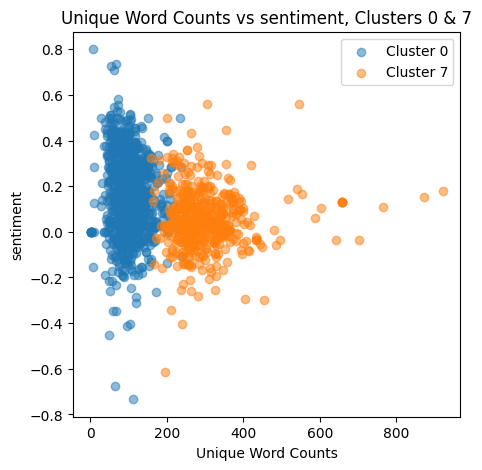

In [19]:
visualize_variables(fit_df, "Unique Word Counts", "sentiment",0,7)

**Analysis:** Unique word counts are one of the key clustering agents that differentiate our newest cluster (7) and our oldest cluster (0). The songs that cluster together that are newest tend to have higher counts of unique words, with a key split at the ~200 mark of unique words. While the songs are identical with regards to the distribution of their sentiment (which we assumed would possibly correlate with the amount of unique words), it is clear that the newest cluster tends to associate with higher complexity/variation.

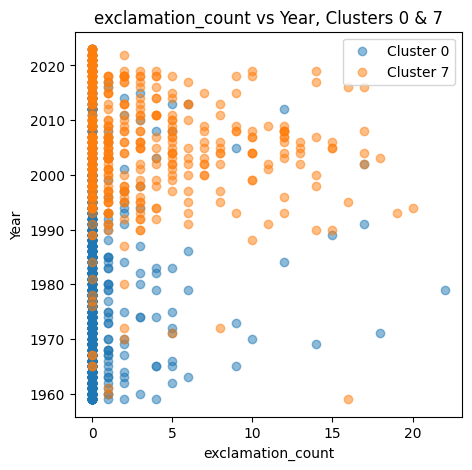

In [20]:
visualize_variables(fit_df, "exclamation_count", "Year",0,7)

**Analysis:** Another variable with observed nuance in our dataset is the count of exclamation marks present. It is important to interpret the above graph by disregarding the dense line at *exclamation_count* = 0. For the songs that do in fact have exclamation marks, the songs from our oldest cluster (cluster 0) tend to have much less frequency of exclamation marks, and less songs that have any exclamation marks at all. We will likely attribute this to better documentation of lyrics and nuance in distribution strategies as artists progress into the late 20th and early 21st century.

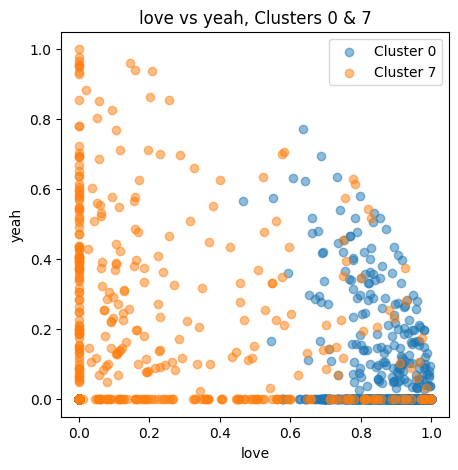

In [22]:
visualize_variables(fit_df, "love", "yeah", 0,7)

**Analysis:** We add a final graph plotting TF (technically TF-IDF, but IDF is constant for both words) of "yeah" against "love." As mentioned before, "love" is much more prevalent in our older cluster (0) in comparison to our newer cluster (7). "yeah" is not as extreme in its TF split, but it is interesting to observe that while "yeah" tends to hover closer to the 0-point for cluster 0, "yeah" is much more spread out for newer songs (cluster 7). The few old songs that have a high frequency of "yeah" also have a high frequency of "love." For the new songs, however, there are a number of songs with no mention of "love" that have high indeces of "yeah."

# Testing Rank
We perform the same two steps, but try to find associations with "Rank" (how high the song charted).
### a. Ranking by rank and aggregating averages
We begin by ranking all of our clusters by the average rank and isolating the highest and lowest ranked clusters.

In [22]:
rank_var(fit_df, "Rank")

Max: 100.0
Min: 1.0
k_cluster
8     44.571429
3     47.410931
5     49.460069
0     49.507447
11    50.515909
12    50.576655
10    50.622845
6     50.864341
1     50.887097
4     51.361667
7     51.898520
9     51.942688
2     52.944444
Name: Rank, dtype: float64


In [23]:
cluster_8 = cluster_averages.iloc[8]
cluster_2 = cluster_averages.iloc[2]
comparison1 = pd.concat([overall_mean, cluster_2, cluster_8], axis=1)
comparison1.columns = ['total mean', 'cluster 2 mean', 'cluster 8 mean'] # rename columns
comparison1.dropna()

,total mean,cluster 2 mean,cluster 8 mean
baby,0.163975,0.123588,0.156566
don,0.197333,0.220347,0.209161
got,0.154585,0.159289,0.207148
just,0.183099,0.202118,0.205650
know,0.193364,0.223804,0.188559
let,0.125657,0.153027,0.107883
like,0.191393,0.213287,0.271792
love,0.251918,0.264326,0.266042
want,0.109905,0.131073,0.121852
yeah,0.161614,0.172232,0.124190


### b. Visualize relationships in data

Using the *visualize_variables* function from our *clustering.py* scrypt, we can easily plot variables against each other for desired clusters (in this case, 2 and 8). We will Plot variables of interest that show key differences across the highest and lowest ranked clusters. 

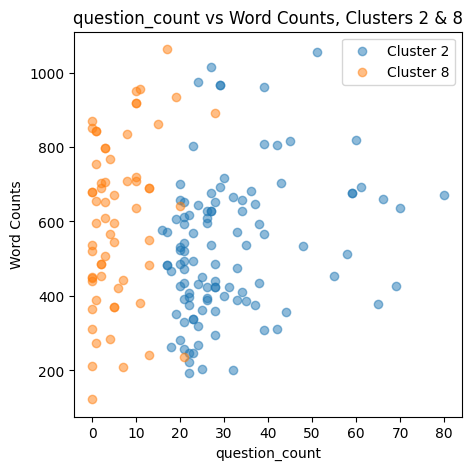

In [24]:
visualize_variables(fit_df, "question_count", "Word Counts",2,8)

**Analysis:** Songs in cluster 8 perform better than songs in cluster 2. Interestingly enough, they almost always have a lower number of question marks as well, indicating that punctuation indicating uncertainty tends to cluster with songs ranked lower (albeit, still in the top 100).

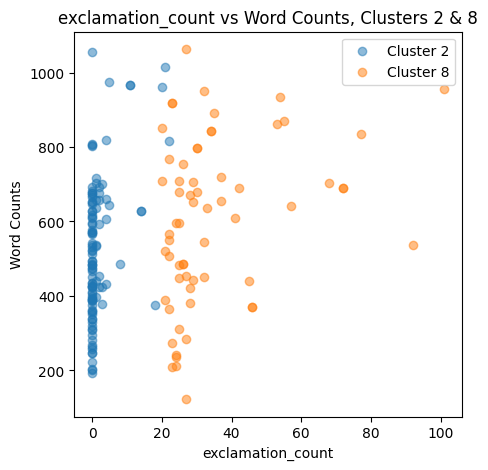

In [25]:
visualize_variables(fit_df, "exclamation_count", "Word Counts",2,8)

**Analysis:** Ironically, we see an opposite effect for exclamation marks, which tend to associate with lower density in the worse-performing songs and higher density in the better-performing songs. 

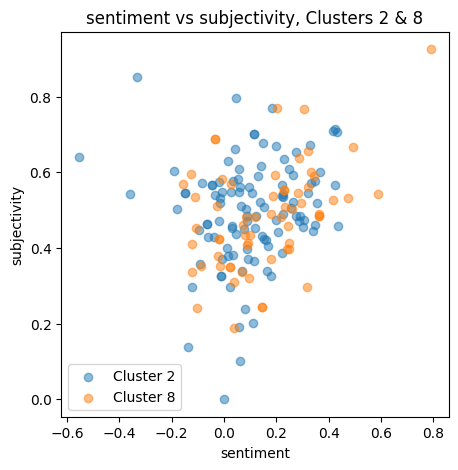

In [35]:
visualize_variables(fit_df, "sentiment", "subjectivity",2,8)

**Analysis:** We observe relatively consistent/undifferentiated sentiment and subjectivity amongst the two clusters, indicating that it does not tend to cluster with a higher or lower rank.